# OVO Tutorial #2
# RENAME THIS FILE WITH YOUR LAST NAME

e.g., my name is Tony Silveti-Falls, so I would rename this file:

```
TP2_Silveti-Falls.ipynb
```

### Setup and Imports

In [176]:
# Libraries
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import cv2


# Denoising with the ROF Model

## The ROF model 
The ROF model for the forward model $x_d = x + \delta$ is given by
$$\min\limits_{u\in\mathbb{R}^{790\times790}}\frac{1}{2}\|u-x_d\|^2 + \lambda\|\nabla u\|_1$$
with $\nabla:\mathbb{R}^{790\times 790}\to(\mathbb{R}^{790\times 790})^2$

Load the noisy cat image ```cat_noise.png``` and store it as a numpy array.

(790, 790)


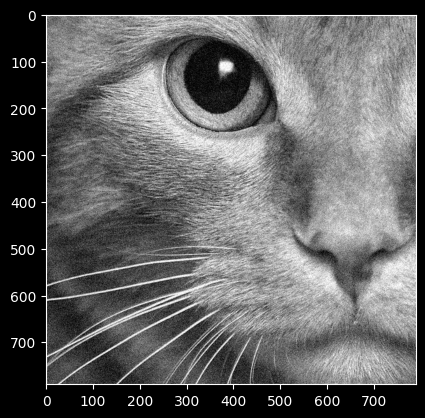

In [177]:
img = Image.open('cat_noise.png')
noisy_cat_array = np.array(img)
print(noisy_cat_array.shape)
plt.style.use('dark_background')
plt.imshow(img,cmap='gray')

## The Rockafellar-Fenchel duality theorem 


The duality theorem tells us that for $f\in\Gamma_0(\mathbb{R}^{n\times n}, g\in\Gamma_0((\mathbb{R}^{n\times n})^2), K:\mathbb{R}^{n\times n}\to (\mathbb{R}^{n\times n})^2$ (and qualification conditions, see 15.24 in Bauschke and Combettes)


$$\min\limits_{u\in\mathbb{R}^{n\times n}} f(u) + g(Ku) \iff \min\limits_{z\in(\mathbb{R}^{n\times n})^2}f^*(K^*z) + g^*(-z)$$



### Applied to the ROF problem

In our case, $f(u)=\frac{1}{2}\|u-x_d\|^2$ and $g(Ku) = \lambda \|\nabla u\|_1$, where $K = \nabla $

Using the Rockafellar-Fenchel duality theorem, the dual problem is:
$$
\min_{z \in (\mathbb{R}^{n \times n})^2} f^*(K^* z) + g^*(-z)
$$

#### Finding the conjugate of $f$

The general formula for the conjugate of a quadratic function $f(u) = \frac{1}{2} \|u - a\|^2 $ is:

$$
f^*(v) = \frac{1}{2} \|v\|^2 + v^\top a
$$

Thus, the conjugate $f^*(K^*z)$ is:

$$
f^*(K^* z) = \frac{1}{2} \| K^* z \|^2 + \langle K^* z, x_d \rangle
$$

In [178]:
def f_star(v, x_d):
    return 0.5 * np.sum(v ** 2) + np.sum(v * x_d)

#### Finding the conjugate of $g$

The conjugate of $ g(v) = \lambda \|v\|_1 $ is the indicator function of the set $ \|v\|_\infty \leq \lambda $:

$$
g^*(-z) = 
\begin{cases} 
0 & \text{if } \|z\|_\infty \leq \lambda \\
\infty & \text{otherwise}
\end{cases}
$$


In [179]:
def g_star(z, lam):
    if np.max(np.abs(z)) <= lam:
        return 0  
    else:
        return np.inf 

#### Finding the adjoint of $\nabla$


Recall that in general an adjoint is the unique linear associated to a linear operator $A:\mathcal{X}\to\mathcal{Y}$ between Hilbert spaces $\mathcal{X}$ and $\mathcal{Y}$ such that
$$\langle Ax, y\rangle = \langle x, A^*y\rangle$$
for all $x\in\mathcal{X}$ and all $y\in\mathcal{Y}$. So, the trick to calculating the adjoint is to write down the inner product between $Ax$ and $y$ and try to rewrite this as an inner product of "something" with just $x$. Whatever the "something" we get is, that is the adjoint.


Note: for this problem we will assume that $\nabla$ is discretized according to the forward finite difference scheme with periodic boundary conditions (meaning we assume that $x_{1,j}$ and $x_{790,j}$ are neighbors for all $1\leq j\leq 790$ and similarly for the rows.

The adjoint of $\nabla$ is the divergence operator, which computes the backward finite differences in place of the forward finite differences in the case of the gradient.

In [180]:
def nabla_adjoint(v):
  v1, v2 = v
  n, m = v1.shape
  result = np.zeros((n,m))
  
  #calculate horizontal differences
  for i in range(n):
      for j in range(m):
          result[i,j] += v1[i,j] - v1[(i-1)%n,j]
          
  #calculate vertical differences
  for i in range(n):
      for j in range(m):
          result[i,j] += v2[i,j] - v2[i,(j-1)%m]

  return -result #correcting a sign error exposed in the following test, we indeed need -div instead of div

Check that the adjoint is computed correctly:

In [181]:
def nabla(x):
    n, m = x.shape
    nabla_x = np.zeros((n, m))
    nabla_y = np.zeros((n, m))
    # Forward difference along rows (x-axis)
    for i in range(n):
        for j in range(m):
            nabla_x[i, j] = x[(i + 1) % n, j] - x[i, j]
    # Forward difference along columns (y-axis)
    for i in range(n):
        for j in range(m):
            nabla_y[i, j] = x[i, (j + 1) % m] - x[i, j]
    return nabla_x, nabla_y

#random testing
n, m = 790, 790
np.random.seed(0)  
x = np.random.rand(n, m)
v1 = np.random.rand(n, m)
v2 = np.random.rand(n, m)
v = (v1, v2)

nabla_x = nabla(x)
adjoint_v = nabla_adjoint(v)


inner_product_1 = np.sum(nabla_x[0] * v1) + np.sum(nabla_x[1] * v2)
inner_product_2 = np.sum(x * adjoint_v)

print(f"product 1: {inner_product_1}")
print(f"product 2: {inner_product_2}")


product 1: 179.49712834990402
product 2: 179.49712834990402


## Applying Forward-Backward splitting

You may assume that the operator norm of $\nabla^*\nabla$ is bounded in this setting (periodic boundary conditions, neighbors only vertical/horizontal) by $8$.

#### Implementing the Forward-Backward algorithm


<FONT COLOR="#ff0000">Note: the formula to recover the primal solution from the dual solution should be $x_d + \nabla^*y^\star$ where $y^\star$ is a dual solution.</FONT>

In [182]:
def forward_backward(x_d, max_iter=100, tau=0.25, lam=1.0, tol=1e-6):
    n, m = x_d.shape
    y = (np.zeros((n, m)), np.zeros((n, m)))  # Dual

    for k in range(max_iter):
        nabla_adj_y = nabla_adjoint(y)
        grad = nabla(x_d + nabla_adj_y)

        y_new = (
            y[0] + tau * grad[0],
            y[1] + tau * grad[1]
        )

        #  dual constraint
        norm_y = np.maximum(1, np.sqrt(y_new[0]**2 + y_new[1]**2) / lam)
        y_new = (y_new[0] / norm_y, y_new[1] / norm_y)

        diff_y = np.sum((y_new[0] - y[0])**2 + (y_new[1] - y[1])**2)
        if diff_y < tol:
            y = y_new
            break
        y = y_new

    nabla_adj_y_star = nabla_adjoint(y)
    x_star = x_d + nabla_adj_y_star

    return x_star, y

#### Testing the algorithm

Run the algorithm and plot the objective function values. Plot the image you recover.

In [195]:
denoised_cat, y = forward_backward(noisy_cat_array, max_iter=50, tau=0.25, lam=50, tol=1e-6)

In [200]:
#objective functions
def f(x_star):
    return 0.5 * np.sum((x - noisy_cat_array) ** 2)

def g(x_star, lam=1):
    nabla_x, nabla_y = nabla(x_star)
    return lam*np.sum(np.sqrt(nabla_x ** 2 + nabla_y ** 2))

print(f'Data fidelity (f): {f(denoised_cat)}\n')
print(f'Total Variation g: {g(denoised_cat,lam=50)}\n')

Data fidelity (f): 5872083885.204552
Total Variation g: 10846192209.6005


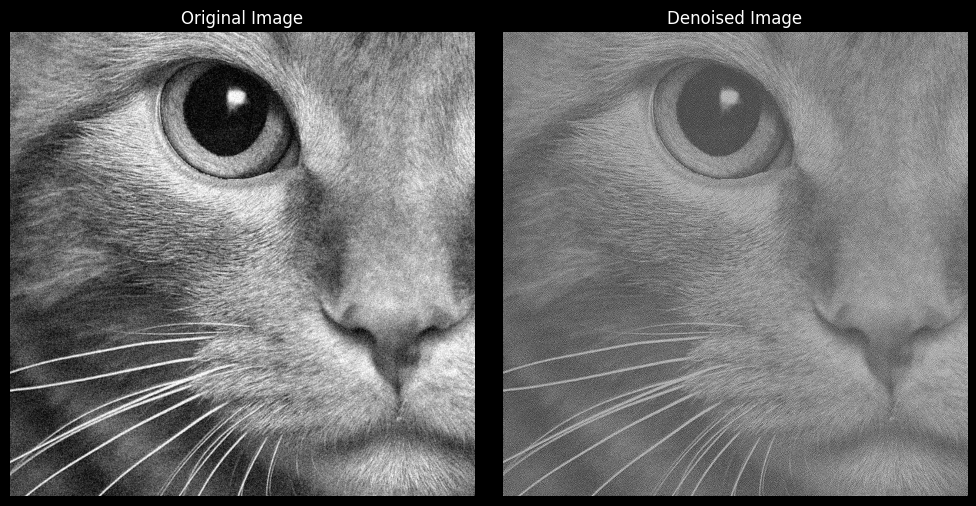

In [197]:
plt.style.use('dark_background')
fig, axes = plt.subplots(1, 2, figsize=(10, 5))  

axes[0].imshow(img, cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')

axes[1].imshow(denoised_cat, cmap='gray')
axes[1].set_title('Denoised Image')
axes[1].axis('off')

plt.tight_layout()  
plt.show()

We can compare the primal and minus the dual functional values; the duality theorem says they should be equal. Plot their difference here.

In [201]:
primal = f(denoised_cat) + g(denoised_cat,lam=50) 
dual = f_star(nabla_adjoint(y), noisy_cat_array) + g_star((-y[0], -y[1]), lam=50)

difference = primal - dual
print(f'Primal: {primal}\n')
print(f'Dual: {dual}\n')
print(f'Difference: {difference}\n')

Primal: 16718276094.805052

Dual: 5950636563.086775

Difference: 10767639531.718277


maybe the convergence was incomplete or there is a mistake in the method. I shall restrict n_iter = 50 for computation time.

## Applying FISTA

Using the same formulation that you used for forward-backward splitting, apply FISTA.

#### Implementing FISTA

In [187]:
def grad_f(u, x_d):
    return u - x_d

def prox_tv(z, lam=1.0, tau = 0.125, n_it=50):
    u = np.copy(z)           # start with u = z
    p1 = np.zeros_like(z)
    p2 = np.zeros_like(z)

    for _ in range(n_it):
        ux = np.roll(u, -1, axis=0) - u
        uy = np.roll(u, -1, axis=1) - u

        # Gradient ascent step on p
        p1_new = p1 + tau * (ux)
        p2_new = p2 + tau * (uy)
        p1_new = np.clip(p1_new, -lam, lam)
        p2_new = np.clip(p2_new, -lam, lam)

        p1, p2 = p1_new, p2_new

        div_p = (p1 - np.roll(p1, 1, axis=0)) + (p2 - np.roll(p2, 1, axis=1))

        u = z - div_p

    return u


def fista_tv_denoising(x_d, lam=1.0, max_iter=50):
    L = 1.0 #given the form of grad f 
    alpha = 1.0 / L  # step size
    
    # Initialize
    u_k = np.copy(x_d)   
    y_k = np.copy(u_k)   
    t_k = 1.0            

    for k in range(max_iter):
        u_old = u_k.copy()

        grad_y = grad_f(y_k, x_d)      # = (y_k - x_d)
        z = y_k - alpha * grad_y       # step
        u_k = prox_tv(z, lam=lam)      # subproblem solve

        t_new = 0.5 * (1.0 + np.sqrt(1.0 + 4.0*(t_k**2)))
        y_k = u_k + ((t_k - 1.0)/t_new) * (u_k - u_old)
        
        t_k = t_new

    return u_k

#### Testing the algorithm

Run the algorithm and plot the objective values. Plot the image you recover.

In [188]:
# Suppose we have a noisy image x_d of shape (n,m).
img = Image.open('cat_noise.png')
noisy_cat_array = np.array(img)
x_d = noisy_cat_array
n, m = x_d.shape

# FISTA
lam = 10
denoised = fista_tv_denoising(x_d, lam=lam, max_iter=10)

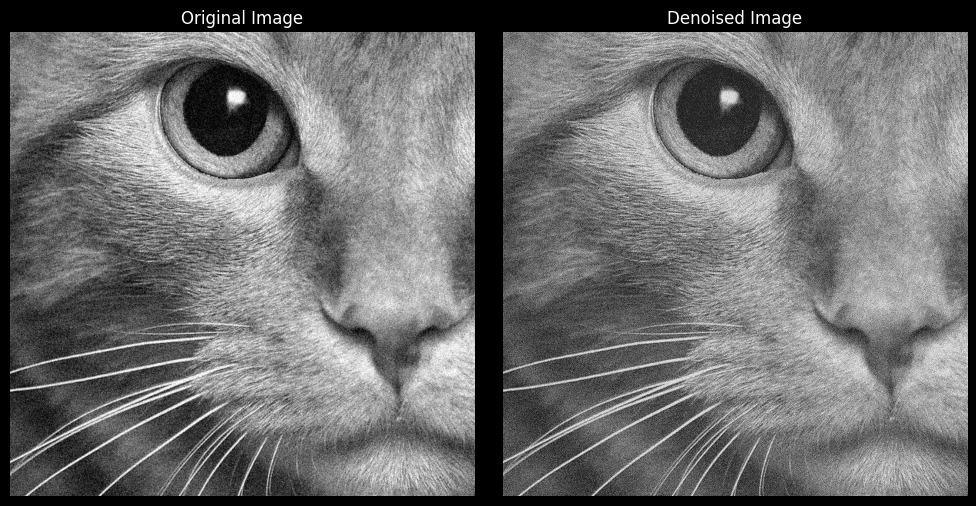

In [189]:
plt.style.use('dark_background')
fig, axes = plt.subplots(1, 2, figsize=(10, 5))  

axes[0].imshow(img, cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')

axes[1].imshow(denoised, cmap='gray')
axes[1].set_title('Denoised Image')
axes[1].axis('off')

plt.tight_layout()  
plt.show()

# Frank-Wolfe for inpainting

We consider the problem of recovering an image given only a partial observation. This is also known as inpainting. We will model our prior on the distribution of natural images as those images whose nuclear norm is sufficiently small, i.e.,
$$\min\limits_{x\in\mathcal{B}} \frac{1}{2}\|Ax-b\|_2^2$$
where $\mathcal{B}$ is the nuclear norm ball of radius $\rho>0$, $A$ is the linear operator (mask) that maps $x$ to its partial observations, and $b$ is partial observation of the ground truth, possibly corrupted by AWGN.

Write a function that generates a random mask, that can be used to model $A$, as a function of the percentage of entries observed.

In [190]:
def generate_random_mask(shape, p):
    random_matrix = np.random.rand(*shape)
    mask = (random_matrix < p).astype(np.float32)
    return mask

Write a function that computes the linear minimization oracle associated to $\mathcal{B}$ as a function of $\rho$ the radius of the ball.

In [191]:
def linear_minimization_oracle(C, rho):
    U, S, Vt = np.linalg.svd(C, full_matrices=False)  
    u1 = U[:, 0].reshape(-1, 1)  
    v1 = Vt[0, :].reshape(1, -1)  
    s1 = S[0] 
    X_lmo = -rho * np.outer(u1, v1)
    return X_lmo

Write a function to compute the objective $f(x)$.

In [192]:
def objective(x, A, b):
    return 0.5 * np.linalg.norm(A * x - b)**2

Write the Frank-Wolfe algorithm and apply it using a mask that you generate applied to the image house_noise
.jpg with $\rho = 1000$ for 500 iterations.

In [193]:
def frank_wolfe(A, b, mask, rho, num_iterations):
    X = np.zeros_like(b)
    for t in range(num_iterations):
        grad = A.T @ (A @ X - b)
        U, S, Vt = np.linalg.svd(grad, full_matrices=False)
        X_lmo = -rho * np.outer(U[:, 0], Vt[0, :])
        step_size = 2 / (t + 2)
        X = X + step_size * (X_lmo - X)
    return X

In [194]:
image_path = "house_noise.jpg"
house_noisy = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
house_noisy = house_noisy.astype(np.float32) / 255.0  # Normalize to [0, 1]

mask = generate_random_mask(house_noisy.shape, p=0.3)
masked_image = house_noisy * mask

rho = 1000
num_iterations = 500

reconstructed_image = frank_wolfe(mask, masked_image, mask, rho, num_iterations)

plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.title("Original Noisy Image")
plt.imshow(house_noisy, cmap="gray")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("Masked Image")
plt.imshow(masked_image, cmap="gray")
plt.axis("off")

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 763 is different from 1077)

Plot the objective function values as well as the so-called Frank-Wolfe gap $\langle \nabla f(x_k), x_k-s_k\rangle$ which is a certificate of optimality.

Apply FISTA to solve this problem and compare the results with the results of Frank-Wolfe in terms of objective values. Start by writing the $\mathrm{prox}$ for the nonsmooth function in this problem.

# SUBMISSION

To submit your file, send an email to:
```
antonio.silveti-falls@centralesupelec.fr
```
with the subject line:
```
TP2_YOURNAME
```
where YOURNAME is your last name, just like in the file name.

**IF YOU DO NOT DO THIS, YOU WILL NOT GET CREDIT FOR YOUR WORK.**